<a href="https://colab.research.google.com/github/MaggiePN92/fastai/blob/master/chap6_gc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 10.5MB/s 
     |████████████████████████████████| 12.8MB 224kB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


#Multi-label classification

Klassifisering av bilder som kan inneholde ingen til flere ulike katetgorier i et bilde. 

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(path/'train.csv')
#what label to use for each img
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


#Constructing a DataBlock

DataFrame -> DataBlock

Dataset; return a tuple independent, dependent variable for single item
DataLoader; an iterator that provides a stream of mini-batches, batch of independent and dependent variables

Datasets/DataLoaders; contains train and val datasets/loaders

Start with dataset, then DataLoader when dataset is working (dataloader builds on dataset) 

In [5]:
dblock = DataBlock()

In [6]:
dsets = dblock.datasets(df)

In [7]:
dsets.train[0]

(fname       009184.jpg
 labels          person
 is_valid         False
 Name: 4605, dtype: object, fname       009184.jpg
 labels          person
 is_valid         False
 Name: 4605, dtype: object)

In [8]:
dblock = DataBlock(get_x= lambda r: r['fname'], get_y=lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('008413.jpg', 'person chair')

In [9]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

dblock = DataBlock(get_x= get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/008057.jpg'), ['car'])

In [10]:
#one-hot encode categories
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x334,
 TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [11]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['boat']

In [12]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

In [13]:
#one-hot encode categories
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

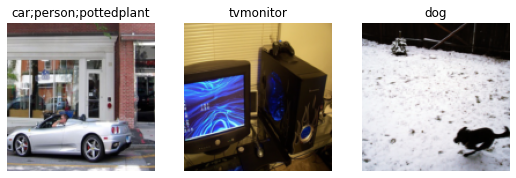

In [14]:
#make sure item is of same size, use RandomResizedCrop
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1,ncols=3)


In [15]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [16]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

RuntimeError: ignored

In [ ]:
activs[0]

In [ ]:
def bce(inp, targ):
  inp = inp.sigmoid()
  return -torch.where(targets==1, inp, 1-inp).log().mean()

binary_cross_entropy_with_logits: calc entropy on one-hot encoded variables
Eq. for single-label data: nll_loss or NLLLoss (without intial softmax) or cross_entropy/CrossEntropyLoss (with initail softmax)

In [17]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

NameError: ignored

In [20]:
def accuracy(inp, targ, axis=1):
  pred = inp.argmax(dim=axis)
  return (pred==targ).float().mean()

In [21]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp=inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

In [23]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.940891,0.712667,0.226275,00:42
1,0.821383,0.559140,0.286633,00:39
2,0.604691,0.195452,0.838665,00:39
3,0.361638,0.125618,0.940259,00:39


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133433,0.120201,0.949641,00:42
1,0.116841,0.108041,0.950418,00:42
2,0.098228,0.104165,0.953367,00:42


In [24]:
#validate returns loss and metrics
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.1041649654507637,0.9345418810844421]

In [25]:
#validate returns loss and metrics
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.1041649654507637,0.943047821521759]

In [26]:
preds, targs = learn.get_preds()

In [27]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9561)

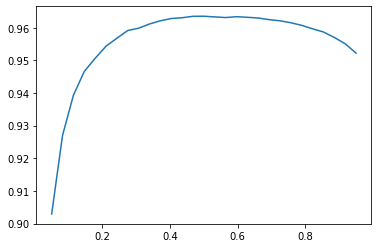

In [28]:
#use list comprehension to plot acc to threshold -> about 0.5 seems best
xs = torch.linspace(0.05, 0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

In [29]:
##Image Regression
#Independent variable is img, dependent is one or more floats
#Predecting row and col for face center

In [30]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/20.obj'),Path('/root/.fastai/data/biwi_head_pose/21'),Path('/root/.fastai/data/biwi_head_pose/22'),Path('/root/.fastai/data/biwi_head_pose/19.obj'),Path('/root/.fastai/data/biwi_head_pose/17'),Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/20'),Path('/root/.fastai/data/biwi_head_pose/06'),Path('/root/.fastai/data/biwi_head_pose/23'),Path('/root/.fastai/data/biwi_head_pose/01.obj')...]

In [31]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00065_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00125_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00231_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00327_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00483_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00323_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00216_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00430_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00286_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00183_pose.txt')...]

In [33]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/21/frame_00738_pose.txt')

In [34]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

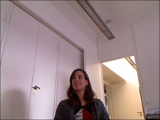

In [35]:
im.to_thumb(160)

In [37]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [38]:
get_ctr(img_files[0])

tensor([326.8349, 313.2342])

In [39]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o:o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)

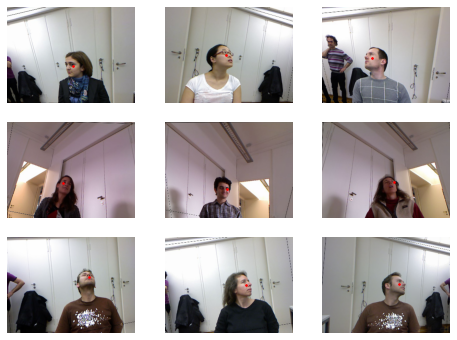

In [40]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [41]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [42]:
yb[0]

TensorPoint([[0.3182, 0.3020]], device='cuda:0')

In [45]:
#y_range gives output range
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [47]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x));
    if tx is not None: ax.set_xlabel(tx);
    if ty is not None: ax.set_ylabel(ty);
    if title is not None: ax.set_title(title);

In [51]:
def sigmoid_range(x,lo,hi): return torch.sigmoid(x) * (hi-lo) + lo

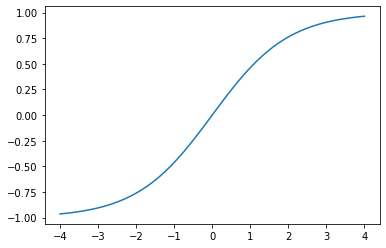

In [53]:
plot_function(partial(sigmoid_range, lo=-1,hi=1), min=-4,max=4)

In [54]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=6.918309736647643e-06)

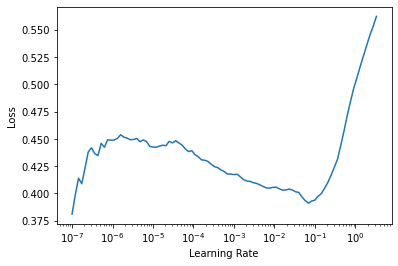

In [55]:
learn.lr_find()

In [56]:
#nn.CrossEntropyLoss for single-label clf
#nn.BCEWithLogitsLoss for multi-label clf
#nn.MSELoss for reg.